# Unsupervised clustering

<div class="alert alert-info">

This tutorial is available as an IPython notebook at [malaya-speech/example/diarization-clustering](https://github.com/huseinzol05/malaya-speech/tree/master/example/diarization-clustering).
    
</div>

<div class="alert alert-info">

This module is language independent, so it save to use on different languages. Pretrained models trained on multilanguages.
    
</div>

<div class="alert alert-warning">

This is an application of malaya-speech Pipeline, read more about malaya-speech Pipeline at [malaya-speech/example/pipeline](https://github.com/huseinzol05/malaya-speech/tree/master/example/pipeline).
    
</div>

### What is Speaker Diarization

In one audio sample, we want to know the timestamp for multiple speakers.

In [1]:
from malaya_speech import Pipeline
import malaya_speech
import numpy as np
import matplotlib.pyplot as plt

### load Speaker Vector

So to know speakers similarity, we can use speaker vector, just load using `malaya_speech.speaker_vector.deep_model`. Read more about malaya-speech Speaker Vector at https://malaya-speech.readthedocs.io/en/latest/load-speaker-vector.html

We are going to compare `conformer-base` and `vggvox-v2`.

In [2]:
model_conformer = malaya_speech.speaker_vector.deep_model('conformer-base')
model_vggvox2 = malaya_speech.speaker_vector.deep_model('vggvox-v2')

### Load audio sample

In [3]:
y, sr = malaya_speech.load('speech/video/The-Singaporean-White-Boy.wav')
len(y), sr

(1634237, 16000)

In [4]:
# just going to take 60 seconds
y = y[:sr * 60]

This audio extracted from https://www.youtube.com/watch?v=HylaY5e1awo&t=2s

### Load VAD

We need to use VAD module to know which parts of the audio sample are speaker activities, read more about VAD at https://malaya-speech.readthedocs.io/en/latest/load-vad.html

In [5]:
vad = malaya_speech.vad.deep_model(model = 'vggvox-v2')

In [6]:
frames = list(malaya_speech.utils.generator.frames(y, 30, sr))

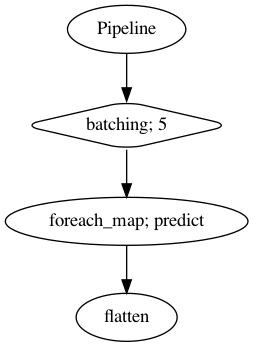

In [7]:
p = Pipeline()
pipeline = (
    p.batching(5)
    .foreach_map(vad.predict)
    .flatten()
)
p.visualize()

In [8]:
%%time

result = p(frames)
result.keys()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=512 is too small for input signal of length=480
  n_fft, y.shape[-1]


CPU times: user 1min 2s, sys: 38.4 s, total: 1min 40s
Wall time: 21 s


dict_keys(['batching', 'predict', 'flatten'])

In [9]:
frames_vad = [(frame, result['flatten'][no]) for no, frame in enumerate(frames)]
grouped_vad = malaya_speech.utils.group.group_frames(frames_vad)
grouped_vad = malaya_speech.utils.group.group_frames_threshold(grouped_vad, threshold_to_stop = 0.3)

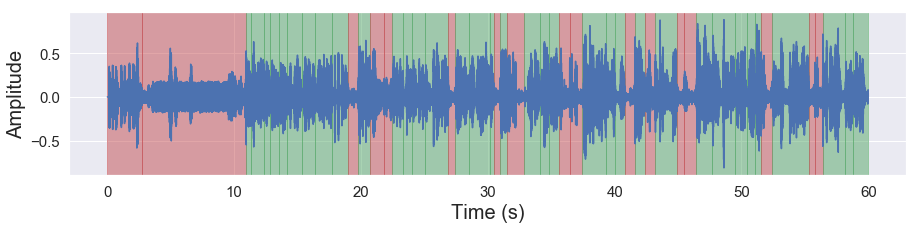

In [10]:
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, figsize = (15, 3))

### Use any clustering model

```python
def clustering(
    vad_results,
    speaker_vector,
    model,
    norm_function: Callable = l2_normalize,
    log_distance_metric: str = None,
    return_embedding: bool = False,
):
    """
    Speaker diarization using any clustering model.

    Parameters
    ----------
    vad_results: List[Tuple[Frame, label]]
        results from VAD.
    speaker_vector: callable
        speaker vector object.
    model: callable
        Any unsupervised clustering model.
        Required `fit_predict` or `apply` or `predict` method.
    norm_function: Callable, optional(default=malaya_speech.utils.dist.l2_normalize)
        normalize function for speaker vectors.
    log_distance_metric: str, optional (default=None)
        post distance norm in log scale metrics.
        this parameter is necessary for model that required square array input.
        Common value is one of ['cosine', 'angular'].

    Returns
    -------
    result : List[Tuple[Frame, label]]
    """
```

So you can use something like `sklearn.cluster.AffinityPropagation` or https://github.com/wq2012/SpectralCluster

### Affinity Propagation

We can use `sklearn.cluster.AffinityPropagation`.

In [11]:
from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation(
    damping=0.8,
    max_iter=100,
    convergence_iter=15,
    preference=None,
    affinity='precomputed',
)

In [14]:
result_diarization_ap_conformer = malaya_speech.diarization.clustering(
    vad_results = grouped_vad, 
    speaker_vector = model_conformer,
    model = ap,
    log_distance_metric = 'cosine',
)
result_diarization_ap_conformer[:5]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/cluster/_affinity_propagation.py:152: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  FutureWarning)


[(<malaya_speech.model.frame.Frame at 0x17bebd2d0>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x17bea4ad0>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x17be99990>, 'speaker 0'),
 (<malaya_speech.model.frame.Frame at 0x17be99910>, 'speaker 5'),
 (<malaya_speech.model.frame.Frame at 0x17be99bd0>, 'speaker 5')]

In [15]:
result_diarization_ap_vggvox2 = malaya_speech.diarization.clustering(
    vad_results = grouped_vad, 
    speaker_vector = model_vggvox2,
    model = ap,
    log_distance_metric = 'cosine',
)
result_diarization_ap_vggvox2[:5]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/cluster/_affinity_propagation.py:152: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  FutureWarning)


[(<malaya_speech.model.frame.Frame at 0x17bebd2d0>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x17bea4ad0>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x17be99990>, 'speaker 2'),
 (<malaya_speech.model.frame.Frame at 0x17be99910>, 'speaker 2'),
 (<malaya_speech.model.frame.Frame at 0x17be99bd0>, 'speaker 4')]

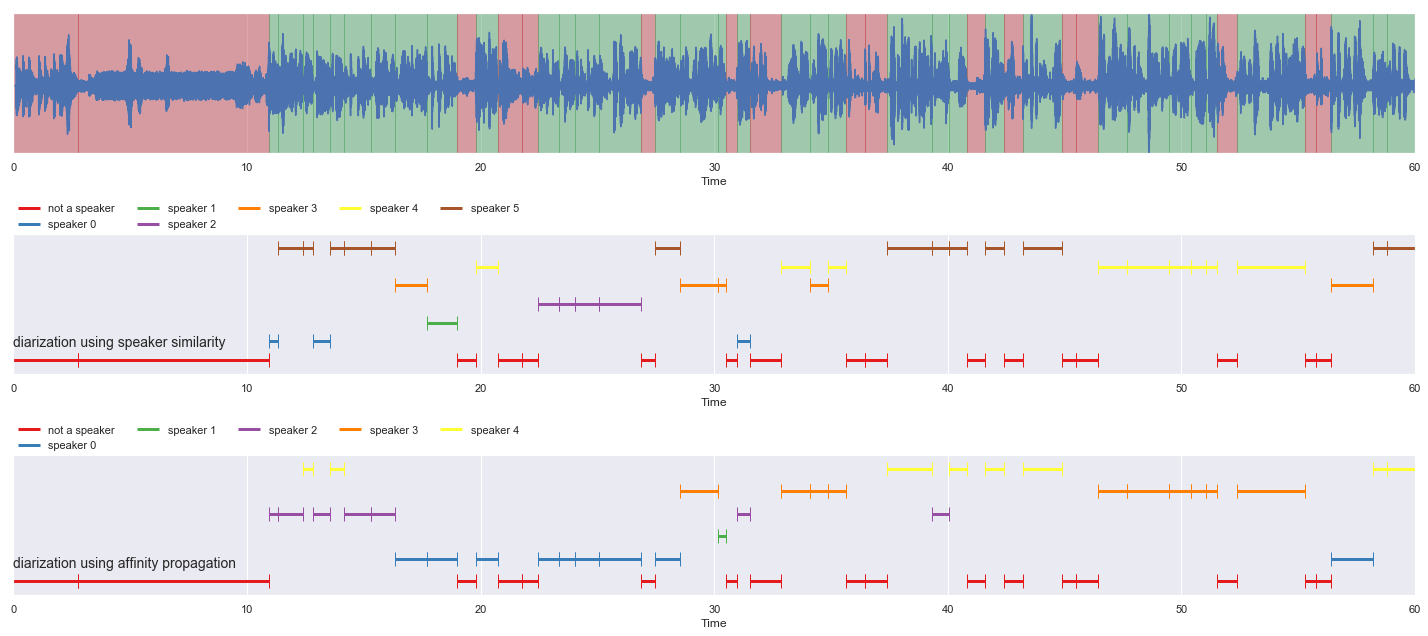

In [18]:
nrows = 3
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 3)
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, ax = ax[0])
malaya_speech.extra.visualization.plot_classification(result_diarization_ap_conformer, 
                                                      'diarization using speaker similarity', ax = ax[1],
                                                     x_text = 0.01)
malaya_speech.extra.visualization.plot_classification(result_diarization_ap_vggvox2, 
                                                      'diarization using affinity propagation', ax = ax[2],
                                                     x_text = 0.01)
fig.tight_layout()
plt.show()

### Spectral Clustering

This is a Python re-implementation of the spectral clustering algorithm in the paper [Speaker Diarization with LSTM](https://google.github.io/speaker-id/publications/LstmDiarization/).

So, make sure you already install [spectralcluster](https://pypi.org/project/spectralcluster/),

```bash
pip install spectralcluster
```

In [24]:
from spectralcluster import SpectralClusterer

clusterer = SpectralClusterer(
    min_clusters=3,
    max_clusters=100,
)

In [25]:
result_diarization_sc_conformer = malaya_speech.diarization.clustering(
    vad_results = grouped_vad, 
    speaker_vector = model_conformer,
    model = clusterer,
)
result_diarization_sc_conformer[:5]

[(<malaya_speech.model.frame.Frame at 0x17bebd2d0>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x17bea4ad0>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x17be99990>, 'speaker 0'),
 (<malaya_speech.model.frame.Frame at 0x17be99910>, 'speaker 0'),
 (<malaya_speech.model.frame.Frame at 0x17be99bd0>, 'speaker 0')]

In [26]:
result_diarization_sc_vggvox2 = malaya_speech.diarization.clustering(
    vad_results = grouped_vad, 
    speaker_vector = model_vggvox2,
    model = clusterer,
)
result_diarization_sc_vggvox2[:5]

[(<malaya_speech.model.frame.Frame at 0x17bebd2d0>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x17bea4ad0>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x17be99990>, 'speaker 2'),
 (<malaya_speech.model.frame.Frame at 0x17be99910>, 'speaker 2'),
 (<malaya_speech.model.frame.Frame at 0x17be99bd0>, 'speaker 2')]

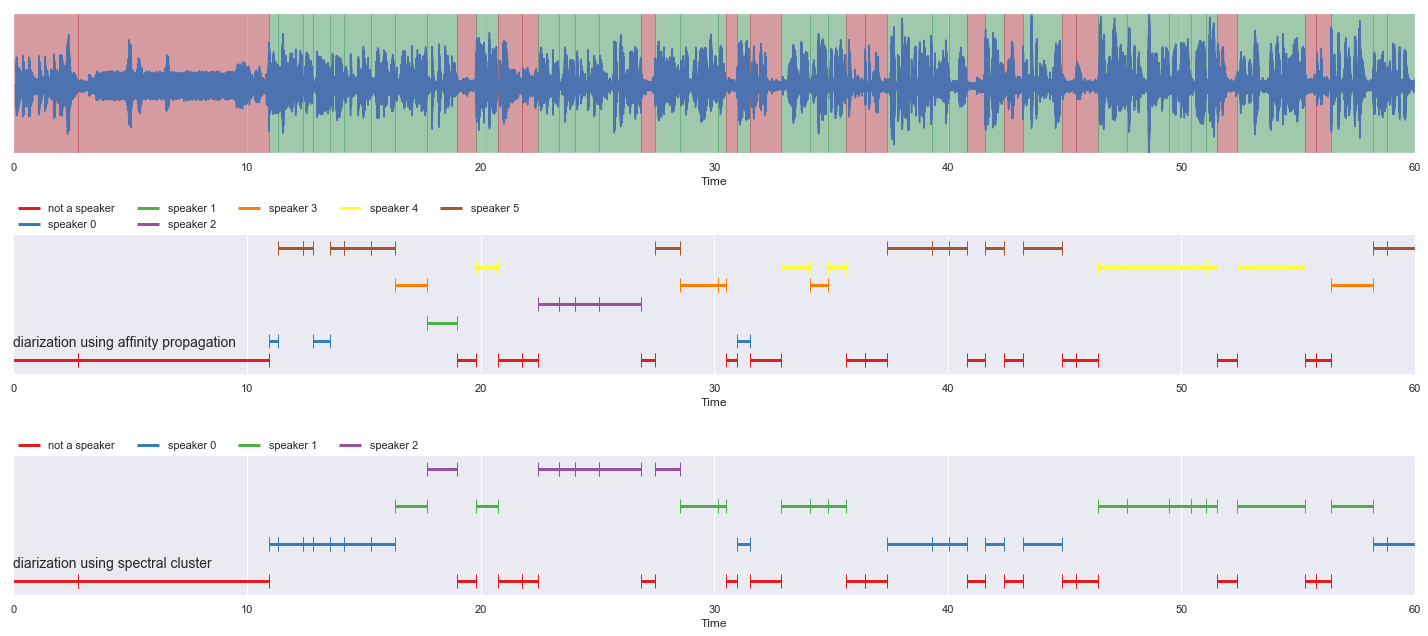

In [27]:
nrows = 3
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 3)
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, ax = ax[0])
malaya_speech.extra.visualization.plot_classification(result_diarization_ap_conformer, 
                                                      'diarization using affinity propagation', ax = ax[1],
                                                     x_text = 0.01)
malaya_speech.extra.visualization.plot_classification(result_diarization_sc_conformer, 
                                                      'diarization using spectral cluster', ax = ax[2],
                                                     x_text = 0.01)
fig.tight_layout()
plt.show()

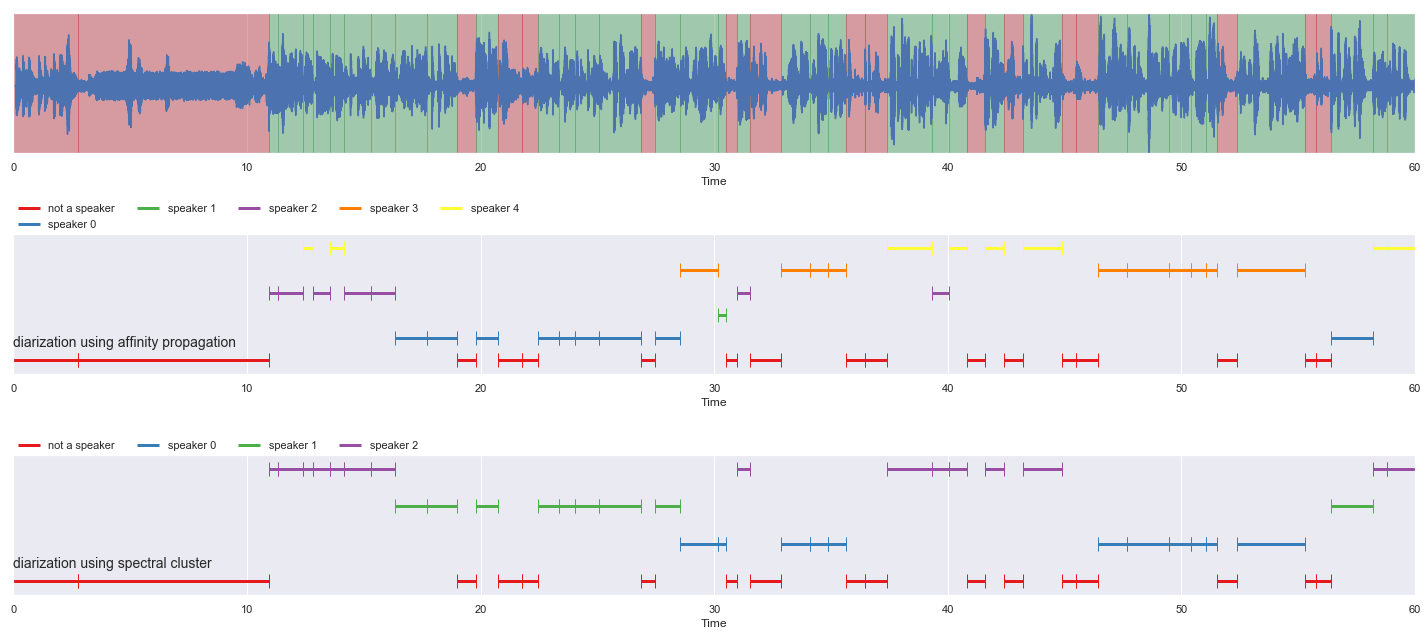

In [28]:
nrows = 3
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 3)
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, ax = ax[0])
malaya_speech.extra.visualization.plot_classification(result_diarization_ap_vggvox2, 
                                                      'diarization using affinity propagation', ax = ax[1],
                                                     x_text = 0.01)
malaya_speech.extra.visualization.plot_classification(result_diarization_sc_vggvox2, 
                                                      'diarization using spectral cluster', ax = ax[2],
                                                     x_text = 0.01)
fig.tight_layout()
plt.show()